#  Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random
import warnings

warnings.filterwarnings('ignore')

# Deep Learning Libraries (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import Sequential, Model, regularizers
from tensorflow.keras.layers import (
    Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout,
    GlobalAveragePooling2D, Activation, Add, GaussianNoise, Reshape, 
    SpatialDropout2D, LeakyReLU, ReLU, Lambda, Input
) 
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model, to_categorical

# Data Analysis and Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
import cv2

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# split data

In [37]:
base_dir = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

In [38]:
classes = ['Cyst', 'Tumor', 'Stone', 'Normal']

In [39]:
data = []
valid_extensions = ('.jpg')  # Supported file extensions

for label in classes:
    folder_path = os.path.join(base_dir, label)

    # Check if the folder exists before attempting to access it
    if not os.path.isdir(folder_path):
        continue  

    for file in os.listdir(folder_path):
        if file.lower().endswith(valid_extensions):  # Support for different extensions
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))



In [40]:
df = pd.DataFrame(data, columns=['file_path', 'label'])

In [41]:
df.head()

,file_path,label
0,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
1,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
2,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
3,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
4,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst


In [42]:
df.shape

(12446, 2)

In [43]:
df['label'].value_counts()

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

# sample for images

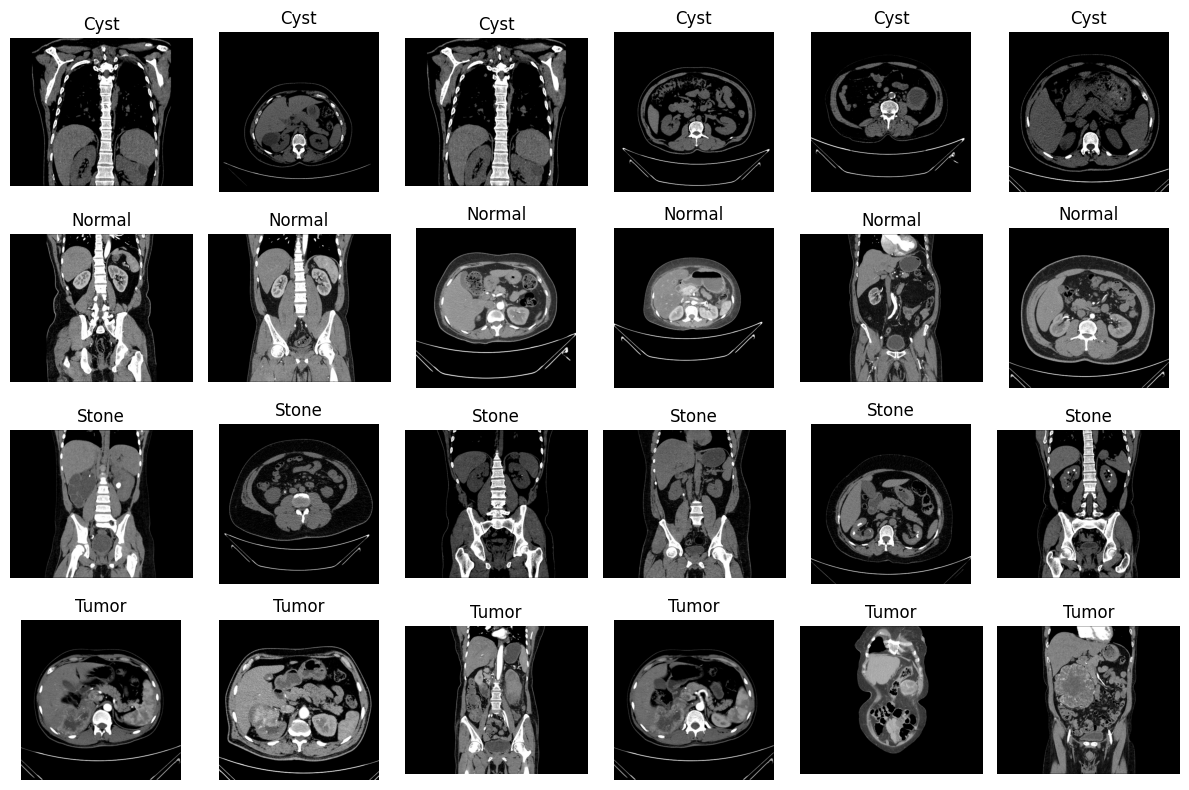

In [44]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of categories to display
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Set up the figure and axes (increase to 6 images per category)
fig, axes = plt.subplots(4, 6, figsize=(12, 8))  # Change columns to display 6 images
axes = axes.flatten()

# Display sample images
for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 6)  

    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        axes[i * 6 + j].imshow(img)  # Correctly set the axis
        axes[i * 6 + j].axis('off')  # Hide the axes
        axes[i * 6 + j].set_title(label)  # Add the category title

plt.tight_layout()
plt.show()


In [47]:
# Assign a numeric value to each category
label_mapping = {'Normal': 1, 'Cyst': 0, 'Stone': 2, 'Tumor': 3}

# Apply the mapping
df['numeric_label'] = df['label'].map(label_mapping)

# Display the DataFrame after modification
print(df[['label', 'numeric_label']])


        label  numeric_label
0        Cyst              0
1        Cyst              0
2        Cyst              0
3        Cyst              0
4        Cyst              0
...       ...            ...
12441  Normal              1
12442  Normal              1
12443  Normal              1
12444  Normal              1
12445  Normal              1

[12446 rows x 2 columns]


In [48]:
df.head()

,file_path,label,numeric_label
0,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,0
1,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,0
2,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,0
3,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,0
4,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,0


In [49]:
import os
import pandas as pd
from pathlib import Path

# Define main dataset directory
train_dir = Path("/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone")

# Define paths for the four categories
normal_cases_dir = train_dir / 'Normal'
cyst_cases_dir = train_dir / 'Cyst'
stone_cases_dir = train_dir / 'Stone'
tumor_cases_dir = train_dir / 'Tumor'

# Retrieve images for each category (assuming jpg files)
normal_cases = list(normal_cases_dir.glob('*.jpg'))
cyst_cases = list(cyst_cases_dir.glob('*.jpg'))
stone_cases = list(stone_cases_dir.glob('*.jpg'))
tumor_cases = list(tumor_cases_dir.glob('*.jpg'))

# Initialize list for training data
train_data = []

# Append main dataset images with labels
for img in cyst_cases:
    train_data.append((str(img), 1))  # Class Cyst = 1
for img in normal_cases:
    train_data.append((str(img), 0))  # Class Normal = 0
for img in stone_cases:
    train_data.append((str(img), 3))  # Class Stone = 3
for img in tumor_cases:
    train_data.append((str(img), 2))  # Class Tumor = 2

# --- Add additional stone images (PNG format) ---
additional_stone_dir = Path("/kaggle/input/kidneystone/CT_SCAN/Kidney_stone")
print("Additional stone directory exists:", additional_stone_dir.exists())

# Search for PNG files in the additional stone directory
additional_stone_cases = list(additional_stone_dir.glob('*.png'))
print("Found", len(additional_stone_cases), "png images in the additional stone directory.")

# If no images found with non-recursive search, try a recursive search (in case images are in subdirectories)
if len(additional_stone_cases) == 0:
    additional_stone_cases = list(additional_stone_dir.glob('**/*.png'))
    print("Found", len(additional_stone_cases), "png images (recursive search) in the additional stone directory.")

# Append additional stone images to the dataset with label 3 (Stone)
for img in additional_stone_cases:
    train_data.append((str(img), 3))  # Class Stone = 3

# Convert the list into a DataFrame
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# Shuffle the data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the updated dataset counts
print("Total dataset counts:")
print(train_data['label'].value_counts())


Additional stone directory exists: True
Found 781 png images in the additional stone directory.
Total dataset counts:
label
0    5077
1    3709
2    2283
3    2158
Name: count, dtype: int64


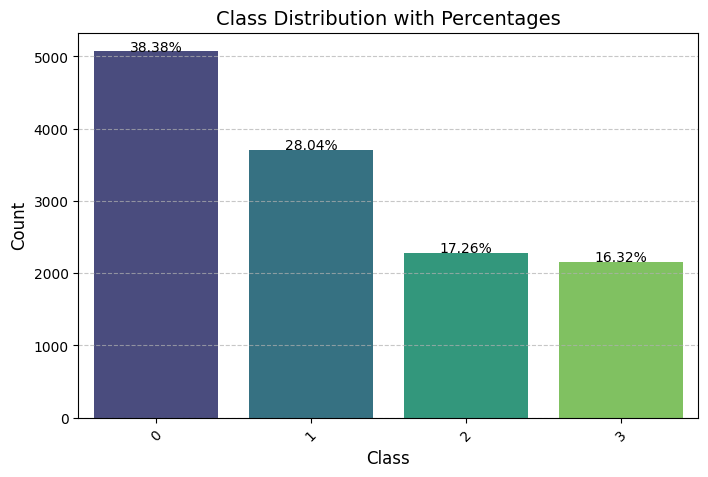

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


value_counts =train_data['label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum() * 100).round(2)
value_counts = value_counts.sort_values(by="count", ascending=False)

plt.figure(figsize=(8, 5))

ax = sns.barplot(data=value_counts, x='label', y='count', palette="viridis")

for i, row in value_counts.iterrows():
    ax.text(i, row['count'] + 2, f"{row['percentage']}%", ha='center', fontsize=10, color='black')

plt.title("Class Distribution with Percentages", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [51]:
# import os
# import pandas as pd
# from pathlib import Path

# train_dir = Path("/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone")


# # Define paths for the four categories
# normal_cases_dir = train_dir / 'Normal'
# cyst_cases_dir = train_dir / 'Cyst'
# stone_cases_dir = train_dir / 'Stone'
# tumor_cases_dir = train_dir / 'Tumor'

# # Retrieve the list of images for each category
# normal_cases = list(normal_cases_dir.glob('*.jpg'))
# cyst_cases = list(cyst_cases_dir.glob('*.jpg'))
# stone_cases = list(stone_cases_dir.glob('*.jpg'))
# tumor_cases = list(tumor_cases_dir.glob('*.jpg'))

# # Create a list of images and their labels
# train_data = []

# for img in cyst_cases:
#     train_data.append((str(img), 1))  # Class Cyst = 1
# for img in normal_cases:
#     train_data.append((str(img), 0))  # Class Normal = 0
# for img in stone_cases:
#     train_data.append((str(img), 3))  # Class Stone = 3
# for img in tumor_cases:
#     train_data.append((str(img), 2))  # Class Tumor = 2

# # Convert the list into a DataFrame
# train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# # Shuffle the data
# train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# # Verify the data
# print(train_data.head())


# Oversampilng

 Before Oversampling:
label
0    5077
1    3709
2    2283
3    2158
Name: count, dtype: int64


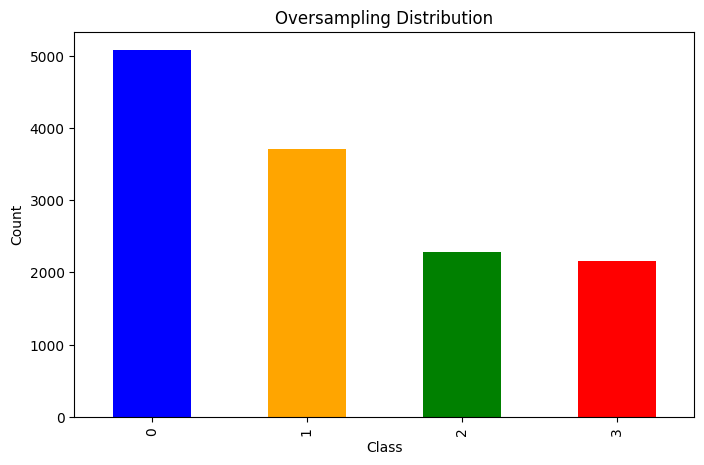

In [52]:
import matplotlib.pyplot as plt

# Calculate the number of samples in each category
class_counts = train_data['label'].value_counts()
print(" Before Oversampling:")
print(class_counts)

# Plot the distribution
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Oversampling Distribution")
plt.show()


After Oversampling:
label
1    5077
0    5077
2    5077
3    5077
Name: count, dtype: int64


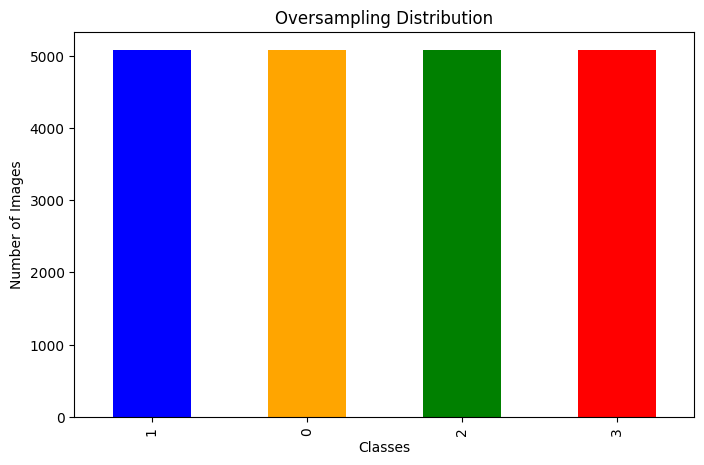

In [53]:
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Calculate the maximum number of samples in any category
max_count = class_counts.max()

# List to store the balanced data
balanced_data = []

# Apply oversampling to each category
for label, count in class_counts.items():
    subset = train_data[train_data['label'] == label]
    if count < max_count:
        subset = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_data.append(subset)

# Combine all categories after balancing
train_data_balanced = pd.concat(balanced_data)

# Shuffle the data randomly
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new distribution
print("After Oversampling:")
print(train_data_balanced['label'].value_counts())

# Plot the distribution after oversampling
plt.figure(figsize=(8,5))
train_data_balanced['label'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Oversampling Distribution")
plt.show()
 

In [54]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Copy of the original training data
train_data_balanced = train_data.copy()

# Create a RandomOverSampler instance to balance the classes
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling to the data
X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])

# Convert the resampled data into a new DataFrame
train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})

# Print the class distribution after oversampling
print(train_data_balanced['label'].value_counts())
    


label
0    5077
3    5077
2    5077
1    5077
Name: count, dtype: int64


# Split the dataset into training (80%) and testing (20%) with stratified sampling

In [55]:
from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and testing (20%) with stratified sampling
train_data, test_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

# Verify the distribution
print("Training Set Distribution:\n", train_data['label'].value_counts())
print("Test Set Distribution:\n", test_data['label'].value_counts())
   

Training Set Distribution:
 label
0    4062
1    2967
2    1826
3    1726
Name: count, dtype: int64
Test Set Distribution:
 label
0    1015
1     742
2     457
3     432
Name: count, dtype: int64


In [56]:

train_data['label'] = train_data['label'].astype(str)


In [57]:
test_data['label'] = test_data['label'].astype(str)


In [58]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create a copy of the original training data
train_data_balanced = train_data.copy()

# Initialize RandomOverSampler to balance class distribution
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling to the dataset
X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])

# Convert the resampled data into a DataFrame
train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})

# Print the class distribution after oversampling
print(train_data_balanced['label'].value_counts())
    


label
2    4062
1    4062
3    4062
0    4062
Name: count, dtype: int64


 # Data Augmentation 

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,           # Normalize pixel values to [0, 1]
    rotation_range=10,       # Rotate images by up to 10 degrees
    width_shift_range=0.12,  # Shift width by up to 12%
    height_shift_range=0.12, # Shift height by up to 12%
    shear_range=0.2,         # Apply shear transformations
    zoom_range=0.2,          # Zoom in or out by up to 20%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels with the nearest values
)

# Initialize ImageDataGenerator for test data without augmentation
test_datagen = ImageDataGenerator(rescale=1/255)

# Apply augmentation to the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_balanced,   
    x_col='image',          # Column name for image paths
    y_col='label',          # Column name for labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=64,           # Use a batch size of 32
    class_mode='categorical', # Use categorical labels
    shuffle=True            # Shuffle data during training
)

# Prepare test data without augmentation
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,    
    x_col='image',          # Column name for image paths
    y_col='label',          # Column name for labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=64,           # Use a batch size of 32
    class_mode='categorical', # Use categorical labels
    shuffle=False           # Do not shuffle test data
)


Found 16248 validated image filenames belonging to 4 classes.
Found 2646 validated image filenames belonging to 4 classes.


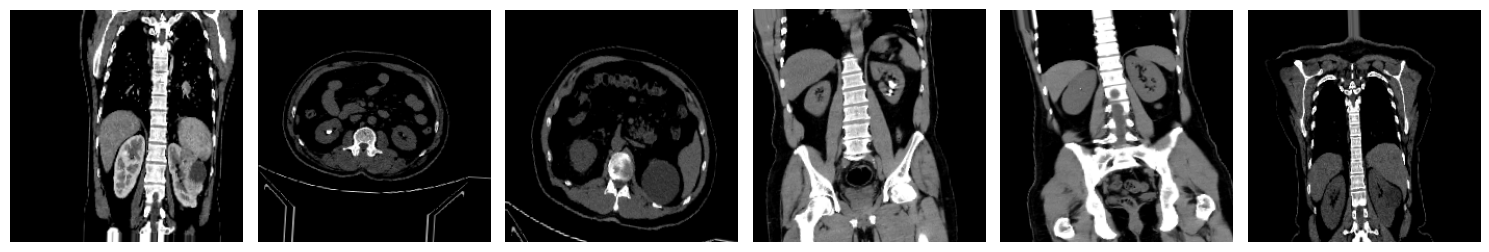

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 6

# Retrieve a batch of images from the generator
augmented_images, _ = next(train_generator)

# Ensure we don't exceed the available images
num_images = min(num_images, augmented_images.shape[0])

# Create a figure and display the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    img = augmented_images[i]
    img = np.clip(img, 0, 1)  # Ensure pixel values are in the [0, 1] range
    axes[i].imshow(img)
    axes[i].axis("off")

plt.tight_layout()
plt.show()
    



# CNN Model

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential()

# First layer: Convolutional + BatchNorm + MaxPooling
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Second layer: Convolutional + BatchNorm + MaxPooling
model.add(Conv2D(64, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Third layer: Convolutional + BatchNorm + MaxPooling
model.add(Conv2D(128, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Fourth layer: Convolutional + BatchNorm + MaxPooling
model.add(Conv2D(256, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Replace Flatten with GlobalMaxPooling2D
model.add(GlobalMaxPooling2D())

# Fully Connected layers
model.add(Dense(256))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(Dense(128))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))

# Output layer: 4-class classification
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Setup Callbacks
checkpoint = ModelCheckpoint('./kidneymodel.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 109, 109, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 256)                 │              

 Total params: 489,540 (1.87 MB)

 Trainable params: 488,580 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [62]:
import tensorflow as tf

Epochs = 100

class UserPromptCallback(tf.keras.callbacks.Callback):
    def __init__(self, prompt_frequency, max_epochs=Epochs):
        super(UserPromptCallback, self).__init__()
        self.prompt_frequency = prompt_frequency
        self.max_epochs = max_epochs
        self.remaining_epochs = prompt_frequency

    def on_epoch_end(self, epoch, logs=None):
        # Stop if max_epochs is reached
        if epoch + 1 >= self.max_epochs:
            print(f"Reached maximum epoch {self.max_epochs}. Stopping training.")
            self.model.stop_training = True
            return

        # Ask user for input every 'prompt_frequency' epochs
        self.remaining_epochs -= 1
        if self.remaining_epochs <= 0:
            response = input(f"Epoch {epoch + 1} completed. Do you want to stop training or add more epochs? (stop/add): ").strip().lower()
            if response == 'stop':
                print("Stopping training as requested by the user.")
                self.model.stop_training = True
            elif response == 'add':
                try:
                    additional_epochs = int(input("How many more epochs to add? ").strip())
                    print(f"Added {additional_epochs} more epochs.")
                    self.max_epochs += additional_epochs  # Extend max_epochs
                    self.remaining_epochs = additional_epochs
                except ValueError:
                    print("Invalid input. Continuing training.")

# Create callback instance
user_prompt_callback = UserPromptCallback(prompt_frequency=20)
# Train model
history = model.fit(
    train_generator,  
    epochs=Epochs,
    callbacks=[checkpoint,early_stopping,reduce_lr, user_prompt_callback],  
    validation_data=test_generator 
) 
model.save('kidneymodel.keras')

# rest test_generator 
test_generator.reset()

# Evaluate on test data   
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')


Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5139 - loss: 1.3553
Epoch 1: val_loss improved from inf to 1.54690, saving model to ./kidneymodel.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.5144 - loss: 1.3536 - val_accuracy: 0.1633 - val_loss: 1.5469 - learning_rate: 1.0000e-04
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.8093 - loss: 0.4996
Epoch 2: val_loss improved from 1.54690 to 0.89602, saving model to ./kidneymodel.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8094 - loss: 0.4994 - val_accuracy: 0.5733 - val_loss: 0.8960 - learning_rate: 1.0000e-04
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.8901 - loss: 0.3025
Epoch 3: val_loss improved from 0.89602 to 0.18700, saving model to ./kidneymodel.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 252s 965ms/step - accuracy: 0.8901 - loss: 0.3024 - val_accuracy: 0.9229 - val_loss: 0.1870 - learning_rate: 1.0000e-04
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━

In [63]:
import matplotlib.pyplot as plt

def plot_metrics(history):
   
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 338ms/step


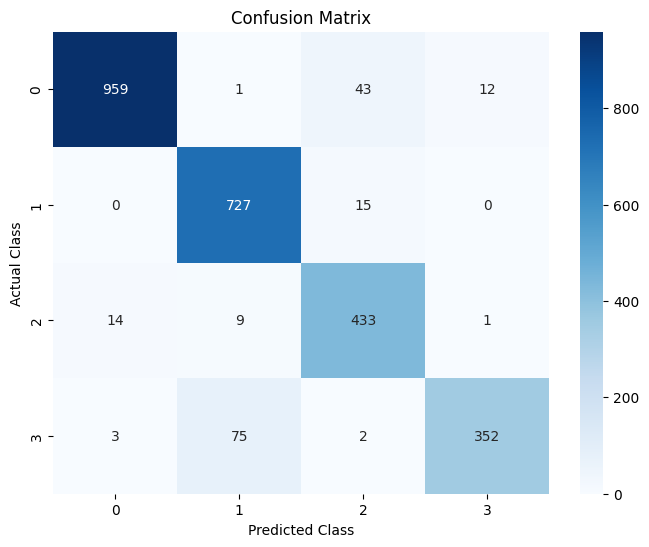

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1015
           1       0.90      0.98      0.94       742
           2       0.88      0.95      0.91       457
           3       0.96      0.81      0.88       432

    accuracy                           0.93      2646
   macro avg       0.93      0.92      0.92      2646
weighted avg       0.94      0.93      0.93      2646



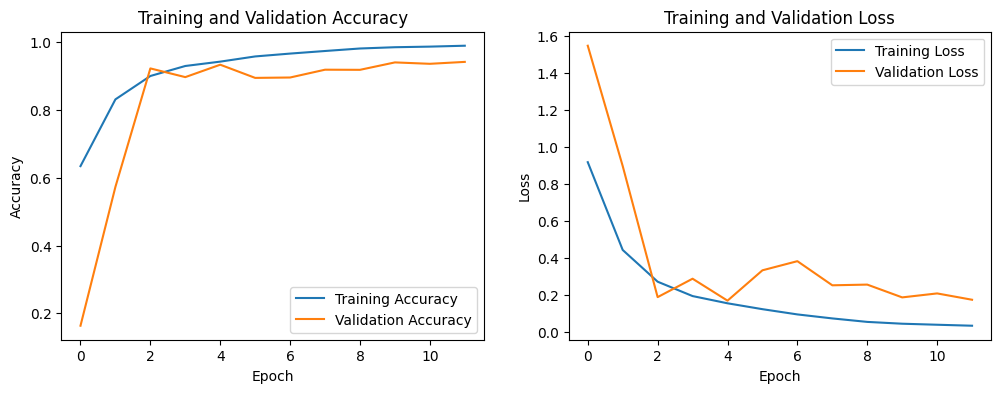

In [64]:
#  Predictions for confusion matrix and classification report
y_true = test_generator.classes  # True labels from the test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted class indices

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))
print("Classification Report:\n", class_report)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
plot_metrics(history)    


In [65]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')


42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.9316 - loss: 0.1800
Test accuracy: 93.39%


In [66]:

model.save('kidney_disease_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
🖼️ Image: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (5000).jpg
✅ True class: Normal
🔍 prediction: Normal
⚡ Confidence: 97.59%


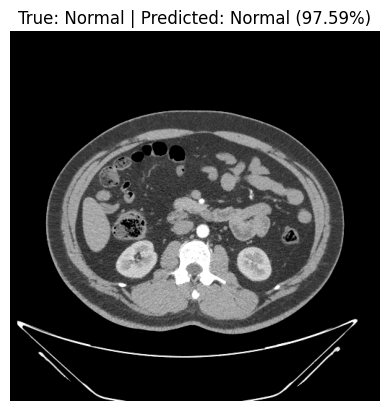

In [67]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


model = load_model('./kidneymodel.keras')

class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

def preprocess_image(image_path):
    """ تجهيز الصورة للنموذج """
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    

    if len(image.shape) == 2:  
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype=np.float32) / 255.0  
    image = np.expand_dims(image, axis=0)  

    return image

def predict_image(image_path):
   
    true_class = os.path.basename(os.path.dirname(image_path))   
    processed_image = preprocess_image(image_path)  

    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    print(f"🖼️ Image: {image_path}")
    print(f"✅ True class: {true_class}")
    print(f"🔍 prediction: {class_names[predicted_class]}")
    print(f"⚡ Confidence: {confidence * 100:.2f}%")

   
    plt.imshow(cv2.imread(image_path)[:, :, ::-1])
    plt.axis('off')
    plt.title(f"True: {true_class} | Predicted: {class_names[predicted_class]} ({confidence * 100:.2f}%)")
    plt.show()
    


image_path = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (5000).jpg'
predict_image(image_path)


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def Kidney_function(model_path,image_path):
    model = load_model(model_path)

    class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']
    
    """ Preprocessing Image"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    # If the model expects 3 channels, expand the grayscale to 3 channels:
    image = np.stack((image,)*3, axis=-1)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    print(f"🖼️ Image: {image_path}")
    print(f"🔍 prediction: {class_names[predicted_class]}")
    print(f"⚡ Confidence: {confidence * 100:.2f}%")
    
    return {class_names[predicted_class]},f"{confidence * 100:.2f}"

In [3]:
import os
def print_all_files(folder_path):
    # Walk through all directories and files within the folder_path
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Join the root directory and file name to form the full path
            file_path = os.path.join(root, file)
            Kidney_function('/kaggle/input/kidney_test/tensorflow2/default/1/kidney_disease_model (1).h5',file_path)

# Example usage:
folder = '/kaggle/input/testing'
print_all_files(folder)  
print("-----------------------")
folder_2 = "/kaggle/input/test-2"
print_all_files(folder_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🖼️ Image: /kaggle/input/testing/Stone.jpeg
🔍 prediction: Stone
⚡ Confidence: 99.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
🖼️ Image: /kaggle/input/testing/Stone (2).jpeg
🔍 prediction: Stone
⚡ Confidence: 99.94%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
🖼️ Image: /kaggle/input/testing/images (12).jpeg
🔍 prediction: Tumor
⚡ Confidence: 72.09%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
🖼️ Image: /kaggle/input/testing/Stone.jpg
🔍 prediction: Stone
⚡ Confidence: 99.94%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
🖼️ Image: /kaggle/input/testing/Cyst- (1).jpg
🔍 prediction: Cyst
⚡ Confidence: 99.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
🖼️ Image: /kaggle/input/testing/Tumor.jpg
🔍 prediction: Tumor
⚡ Confidence: 82.58%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
🖼️ Image: /kaggle/input/testing/Normal (1).jpeg
🔍 prediction: Stone
⚡ Confidence: 51.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
🖼️ Image: /kaggle/input/testing/Normal (2).jpeg
🔍 prediction: Normal
⚡ Confidence: 76.04

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
🖼️ Image: /kaggle/input/proplem-data/WhatsApp Image 2025-03-18 at 19.06.14_da856122.jpg
🔍 prediction: Tumor
⚡ Confidence: 81.63%


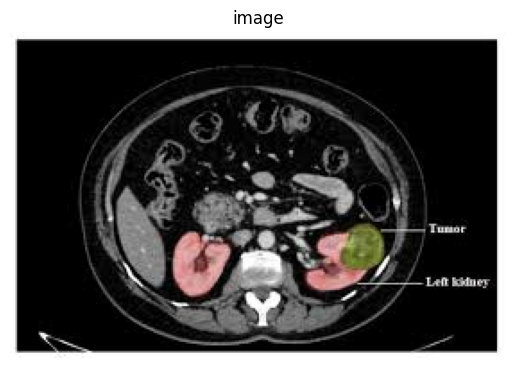

In [11]:
image_path="/kaggle/input/proplem-data/WhatsApp Image 2025-03-18 at 19.06.14_da856122.jpg"
Kidney_function('/kaggle/input/kidney_test/tensorflow2/default/1/kidney_disease_model (1).h5',image_path)
plt.imshow(cv2.imread(image_path)[:, :, ::-1])
plt.axis('off')
plt.title(f"image")
plt.show()